In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse, optimize, linalg

# Baby phase transitions

In this tutorial we study two examples of phase transitions in problems related to datascience, seen in lecture 14.

## Erdós–Rényi random graph

We consider $N$ vertices (_sommets_) $i$ (also called nodes). There are $N(N-1)/2$ non-ordered pairs of vertices $(i,j)$. We connect each pair with an non-oriented edge at random, identically and independantly, with probability $p=d/N$. We consider $N$ large.

In the course part 14.2 you saw that a large connected component appears if $d>1$. A connected component is a set of vertices that are all connected together (there is a path between each pair of vertices) and that are not connected to any other vertex. A large component is a component whose size is a finite fraction of the size of the graph.

In this part we check this numerically.

1 – What is the average degree of such a graph ? We say it is sparse (_épars_) ; why ?

* solution

A vertex is on average connected to $(N-1)d/N\approx d$ other vertices. This is sparse : there are $\sim N$ edges while the total number of possible edges is $\sim N^2$.

2 – Write a function that creates an instance of this graph by returning its adjacency matrix. It should output a symmetric $N\times N$ array whose elements are 0 or 1, for the absence or the presence of an edge, as defined in the course. The diagonal is 0. You may use `np.triu` to symmetrize it.

In [2]:
# solution

def _instance(N, d):
    liens = 1*(np.random.random((N,N))<d/N)
    liens = np.triu(liens, 1)+np.triu(liens, 1).T
    return liens

3 – We use the `connected_components` routine from `sparse.csgraph` from `scipy`. It computes all the connected components of a sparse graph. It returns a tuple `(n, l)` where `n` is the number of components and `l` is an $N$-array that labels each vertex according to the component it belongs to. Run it on a small example to understand the format of `l`.

Write a function that returns the size of the largest component divided by $N$. You may use `np.unique` to count the size of the components.

In [3]:
# solution

def _taille(liens):
    _, composantes = sparse.csgraph.connected_components(liens)
    _, nComposantes = np.unique(composantes, return_counts=True)
    N = np.shape(liens)[0]
    return max(nComposantes)/N

4 – In the course you saw a phase transition appears at $d=1$ in the limit $N$ large. The proportion $\rho$ of nodes occupied by the largest connected component is 0 if $d<1$ and $\rho=1-x/d$ if $d>1$, where $0<x<1$ is the solution of $xe^{-x}=de^{-d}$ over $]0,1[$.

Code a function that computes $\rho$. You can solve the equation with the routine `optimize.bisect` from scipy. This is an implementation of the bisection algorithm.

In [4]:
# solution

def _rho(d):
    f = lambda x, c: x*np.exp(-x)-c*np.exp(-c)
    return 1-optimize.bisect(f, 0, 1, args=(d,))/d

5 – Run your code for about fifteen different $d$. For each $d$ perform ten to thirty trial (i.e. generate 10 to 30 graphs for each $d$) and compute the empirical mean of $\rho$ and its standard deviation. Plot them as a function of $d$ with `plt.plot`. You can use `plt.fill_between` to plot the standard deviation (add some transparancy with the parameter `alpha=0.2`). Take $N=500$ at the beginning ; then on the same graph plot $N=200$, $N=400$ and $N=1200$. Add the theoretical curve $N\to \infty$.

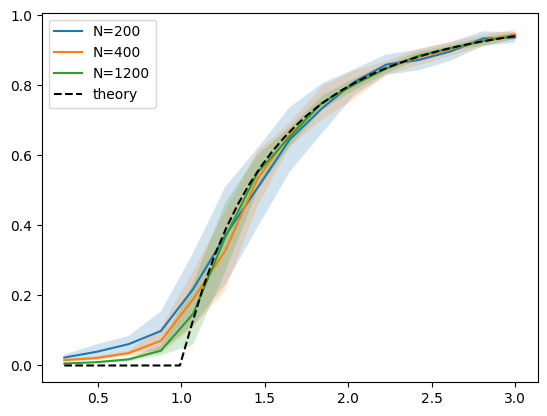

In [5]:
# solution

nExp = 20
ds = np.linspace(0.3, 3, 15)

for N in [200, 400, 1200]:
    tailles = np.zeros((len(ds), nExp))
    for i,d in enumerate(ds):
        for n in range(nExp):
            liens = _instance(N, d)
            taille = _taille(liens)
            tailles[i,n] = taille
    
    m = np.mean(tailles, axis=1)
    s = np.std(tailles, axis=1)
    plt.plot(ds, m, label="N={}".format(N))
    plt.fill_between(ds, m-s, m+s, alpha=0.2)
    
ds = np.linspace(0.3, 3, 40)
taillesTh = []
for d in ds:
    taillesTh.append(_rho(d))
plt.plot(ds, taillesTh, color="black", ls='--', label="theory")    
    
plt.legend()

6 – Observe the transition around the critical $d^*=1$.

_For $d<d^*$ the proportion of the graph occupied by the largest component tends to zero while for $d>d^*$ it converges to a finite value. The transition is sharper for $N$ larger._

## Baik–Ben Arous–Péché transition

We consider a spiked (_piquée_) $N\times N$ random matrix defined by
$$
A = \sqrt{\frac{\mu}{N}} uu^T+\Xi
$$
where $u\in\mathbb R^N$ is the spike, the signal, that contains information and $\Xi$ is symmetric noise. They are distributed according to : $u_i\sim\mathcal N(0,1)$ and $\Xi_{i\leq j}\sim\mathcal N(0,1)$ independantly for $1\leq i\leq j\leq N$. $\mu$ is the signal-to-noise ratio.

In the course section 14.3 you saw that a transition appears at $\mu=1$ : for $\mu<1$ the leading eigenvector of $A$ is uncorrelated with the spike while for $\mu>1$ it is correlated. We investigate this numerically.

7 – Write a function that generates a spike $u$ and one instance of $A$. It should return $A$ and $u$.

In [ ]:
def _A(N, mu):
    

In [6]:
# solution

def _A(N, mu):
    A = np.random.normal(0, 1, (N,N))
    A = np.triu(A, 1)+np.triu(A, 1).T
    u = np.random.normal(0, 1, N)
    A += (mu/N)**0.5*np.outer(u, u)
    return A, u

8 — $A$ is symmetric so its eigenvalues are real. Compute its leading (ie largest in absolute value) eigenvalue $\lambda_1$ and its associated eigenvector $u_1$. You may recall of the iterative power method from your first tutorial, or use the routine `linalg.eigh` from scipy.

In [7]:
# solution
N = 500
mu = 1.5
A, u = _A(N, mu)
vals, vects = linalg.eigh(A, subset_by_index=[N-1,N-1])

9 – We define the overlap as
$$
q_u = \frac{|u^Tu_1|}{||u||\,||u_1||}\ .
$$
It is the cosine of the angle between the two vectors. It quantifies how much information on the signal $u$ one can retrieve given $A$. A non-null overlap means we know information about the direction of the spike.

Compute the overlap.

In the course you saw a phase transition appears at $\mu=1$ in the limit $N$ large. Random matrix theory gives us that $q_u=0$ if $\mu<1$ and $q_u=\sqrt{1-\mu^{-1}}$ else. Implement this function.

In [8]:
# solution
abs(np.sum(vects[:,0]*u))/np.linalg.norm(u)
_rec = lambda mu: ((mu>1)*(1-1/mu))**0.5

10 – Pack your code in a function. Run it for about fifteen different $\mu$. For each $\mu$ perform ten to thirty trials ; take the empirical mean of $q_u$ and its standard deviation. Plot them vs $\mu$ with `plt.plot` and `plt.fill_between`. Take $N=500$ at the beginning ; then on the same graph plot $N=200$, $N=500$ and $N=1500$. Add the theoretical curve $N\to\infty$.

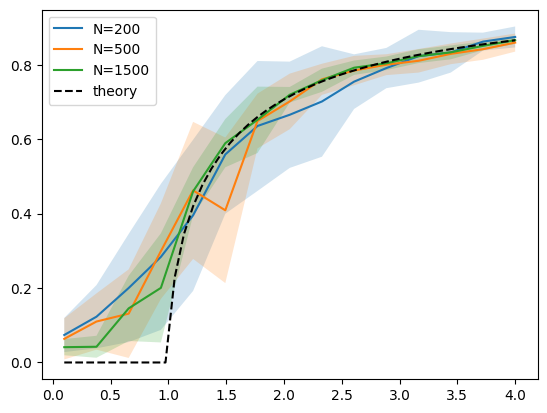

In [9]:
def exp(N, l):
    A, u = _A(N, l)
    vals, vects = linalg.eigh(A, subset_by_index=[N-1,N-1])
    qU = abs(np.sum(vects[:,0]*u))/np.linalg.norm(u)
    return qU

mus = np.linspace(0.1, 4, 15)
nsExp = [30, 15, 10]

for k,N in enumerate([200, 500, 1500]):
    recs = np.zeros((len(mus), nsExp[k]))
    for i,mu in enumerate(mus):
        for n in range(nsExp[k]):
            rec = exp(N, mu)
            recs[i,n] = rec
    
    m = np.mean(recs, axis=1)
    s = np.std(recs, axis=1)
    plt.plot(mus, m, label="N={}".format(N))
    plt.fill_between(mus, m-s, m+s, alpha=0.2)
    
mus = np.linspace(0.1, 4, 50)
plt.plot(mus, _rec(mus), color="black", ls='--', label="theory")

plt.legend()

11 – There is also a transition for $\lambda_1$. To see it, compute all the eigenvalues of $A$, with `linalg.eigvalsh`, rescale them by $1/\sqrt{N}$ and plot their histogram, $\lambda_1$ being excluded. Use around thirty bins. Add a vertical line showing where is $\lambda_1$. Do this once for a few different $\mu$ at $N=3000$.

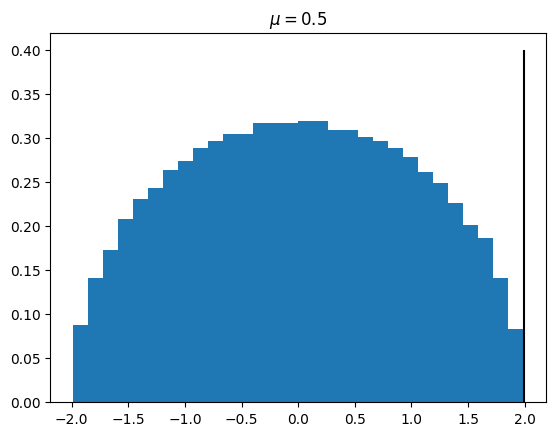

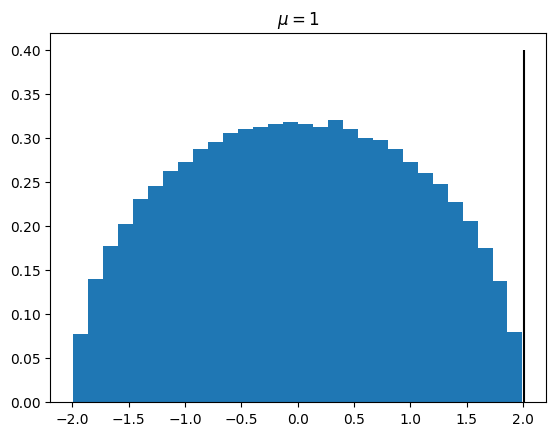

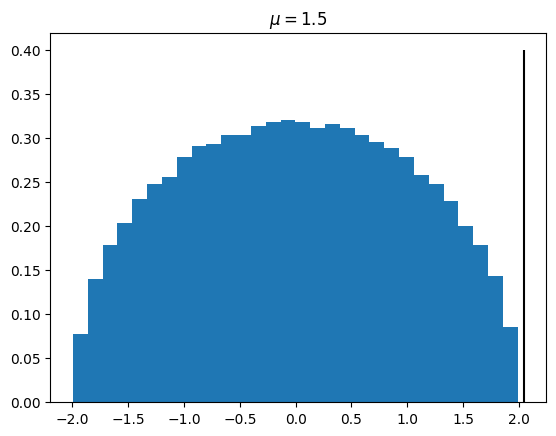

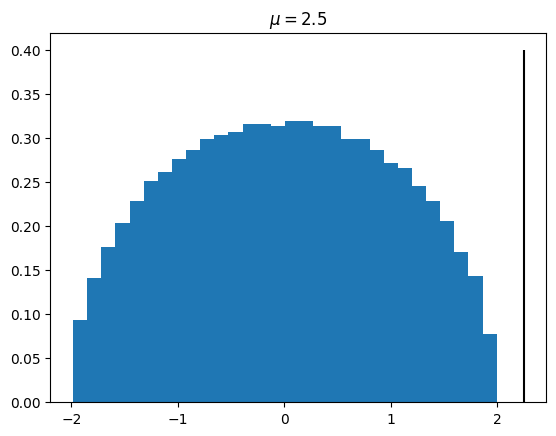

In [10]:
# solution
N = 3000

for mu in [0.5, 1, 1.5, 2.5]:
    A, u = _A(N, mu)
    vals = linalg.eigvalsh(A)*N**-0.5
    l1 = vals[-1]
    plt.hist(vals[:-1], density=True, bins=30)
    plt.vlines(l1, 0, 0.4, color="black")
    plt.title(r"$\mu={}$".format(mu))
    plt.show()

12 – Observe the BBP transition.

_The eigenvalues of $A$ divided by $\sqrt{N}$ form a bulk that spans $[-2,2]$ (they are distributed according to the semi-circle law). When $\mu>1$, $\lambda_1$ emerges from the bulk._